# tSNE of dengue infected Huh7 cells by gene expression - eLife style

In [1]:
import os
import sys
import pickle
import argparse
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['SINGLET_CONFIG_FILENAME'] = 'singlet.yml'
sys.path.append('/home/fabio/university/postdoc/singlet')
from singlet.dataset import Dataset

### Load the data, normalize, add virus info, calculate correlations, etc. etc.

In [2]:
ds = Dataset(
        counts_table='dengue',
        samplesheet='dengue',
        featuresheet='humanGC38',
        )
ds.query_samples_by_counts('total >= 50000', inplace=True)

ds.samplesheet.rename(columns={'time [h]': 'time'}, inplace=True)
cov = ds.samplesheet['coverage'] = ds.counts.sum(axis=0)
ds.counts.normalize('counts_per_million', inplace=True)
ds.samplesheet['virus_reads_per_million'] = 0
for virus in ('dengue', 'zika'):
    ind = ds.samplesheet['virus'] == virus
    n = ds.samplesheet.loc[ind, 'number'+virus.capitalize()+'Reads'].astype(int)
    ds.samplesheet.loc[ind, 'virus_reads_per_million'] = 1e6 * n / (cov.loc[ind] + n)
ds.counts.log(inplace=True)

# Select only some cells for comparison
dsc = ds.copy()
dsc.samplesheet = dsc.samplesheet.query('500 < virus_reads_per_million')

# Get correlations
dsv = dsc.split(phenotypes='virus')
vs = []
cos = []
for virus, dsvi in dsv.items():
    co = dsvi.correlation.correlate_features_phenotypes(
            phenotypes='virus_reads_per_million',
            fillna=0).fillna(0)
    cos.append(co)
    vs.append(virus)
cos = pd.concat(cos, axis=1)
cos.columns = pd.Index(vs, name='virus')

/home/fabio/university/postdoc/singlet/singlet/dataset/correlations.py:37: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T


### Add info on dengue genomics
This data comes from Felix

In [3]:
fn_felix = '../data/metadataD_SNV_with_coverage.pkl'
with open(fn_felix, 'rb') as ff:
    meta_felix = pickle.load(ff)

In [4]:
newcols = set(meta_felix.columns) - set(ds.samplesheet.columns) - set(['qPCR', 'time [h]', 'ID'])
for col in newcols:
    ds.samplesheet[col] = meta_felix.loc[ds.samplesheet.index, col]

### Plot tSNE all cells
Here all cells in the dengue experiment are kept for now, including uninfected controls and bystanders.

/usr/lib/python3.7/site-packages/matplotlib/quiver.py:717: RuntimeWarning: invalid value encountered in less
  short = np.repeat(length < minsh, 8, axis=1)
/usr/lib/python3.7/site-packages/matplotlib/quiver.py:731: RuntimeWarning: invalid value encountered in less
  tooshort = length < self.minlength


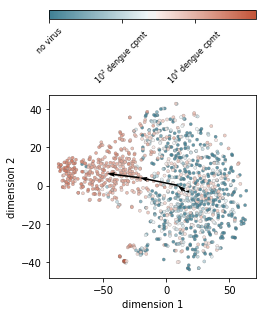

In [5]:
# Plot dimensionality reductions for all genes at the ourskirts of the correlation plot
dsd = ds.copy()
features = cos.index[np.abs(cos).max(axis=1) >= 0.4]
dsd.counts = dsd.counts.loc[features]
dsd.samplesheet['virus_log'] = np.log10(1 + dsd.samplesheet['virus_reads_per_million'])
# t-SNE is not deterministic, so save to file to make sure we can reproduce
# the paper figures with variations if needed
vs_fn = '../data/tsne_coordinates_allcells.tsv'
if os.path.isfile(vs_fn):
    vs = pd.read_csv(vs_fn, sep='\t', index_col=0)
else:
    vs = dsd.dimensionality.tsne(perplexity=10)
    vs.to_csv(vs_fn, sep='\t')
cmap = sns.diverging_palette(220, 20, as_cmap=True, center='light')
fig, axs = plt.subplots(
        nrows=2, ncols=1, figsize=(3.8, 4.5),
        gridspec_kw={'height_ratios': [1, 20]})
axs = axs[::-1]
dsd.plot.scatter_reduced_samples(
        vs,
        color_by='virus_log',
        cmap=cmap,
        alpha=0.8,
        ax=axs[0],
        s=10,
        lw=.25,
        edgecolor=[0.4, 0.4, 0.4],
        zorder=10)
norm1 = mpl.colors.Normalize(
        vmin=dsd.samplesheet['virus_log'].values.min(),
        vmax=dsd.samplesheet['virus_log'].values.max())
cb1 = mpl.colorbar.ColorbarBase(
        ax=axs[1], cmap=cmap, norm=norm1, orientation='horizontal')
cb1.set_ticks([-4, -2, 0, 2, 4])
cb1.set_ticklabels(
        ['$10^4$ Zika cpmt', '$10^2$ Zika cpmt', 'no virus',
         '$10^2$ dengue cpmt', '$10^4$ dengue cpmt'])
for tkl in cb1.ax.get_xticklabels():
    tkl.set_rotation(45)
    tkl.set_fontsize(8)
axs[0].grid(False)

# Plot mean of samples at increasing viral load
bins = [0, 30, 200, 1000, 10000, 70000, 500000]
for virus in ['dengue', 'zika']:
    ph = dsd.samplesheet['virus_reads_per_million']
    vi = dsd.samplesheet['virus']
    vms = pd.concat([vs.loc[
        (ph >= bins[i]) & (ph < bins[i+2]) & (vi == virus)
        ].mean(axis=0) for i in range(len(bins) - 2)],
        axis=1).T
    x = vms.values[:, 0]
    y = vms.values[:, 1]
    axs[0].quiver(
            x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1],
            scale_units='xy', angles='xy', scale=1,
            zorder=20)

plt.tight_layout(h_pad=0.5, w_pad=0.1)

### Plot tSNE cells MOI 1, 10
Including bystanders but not uninfected controls.

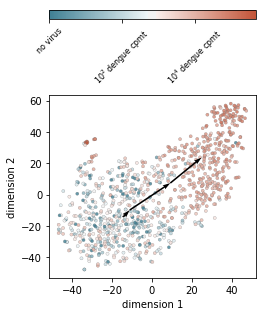

In [6]:
# Plot dimensionality reductions for all genes at the ourskirts of the correlation plot
dsd = ds.query_samples_by_metadata('MOI in (1, 10)')
features = cos.index[np.abs(cos).max(axis=1) >= 0.4]
dsd.counts = dsd.counts.loc[features]
dsd.samplesheet['virus_log'] = np.log10(1 + dsd.samplesheet['virus_reads_per_million'])
# t-SNE is not deterministic, so save to file to make sure we can reproduce
# the paper figures with variations if needed
vs_fn = '../data/tsne_coordinates_moi1-10.tsv'
if os.path.isfile(vs_fn):
    vs = pd.read_csv(vs_fn, sep='\t', index_col=0)
else:
    vs = dsd.dimensionality.tsne(perplexity=10)
    vs.to_csv(vs_fn, sep='\t')
cmap = sns.diverging_palette(220, 20, as_cmap=True, center='light')
fig, axs = plt.subplots(
        nrows=2, ncols=1, figsize=(3.8, 4.5),
        gridspec_kw={'height_ratios': [1, 20]})
axs = axs[::-1]
dsd.plot.scatter_reduced_samples(
        vs,
        color_by='virus_log',
        cmap=cmap,
        alpha=0.8,
        ax=axs[0],
        s=10,
        lw=.25,
        edgecolor=[0.4, 0.4, 0.4],
        zorder=10)
norm1 = mpl.colors.Normalize(
        vmin=dsd.samplesheet['virus_log'].values.min(),
        vmax=dsd.samplesheet['virus_log'].values.max())
cb1 = mpl.colorbar.ColorbarBase(
        ax=axs[1], cmap=cmap, norm=norm1, orientation='horizontal')
cb1.set_ticks([-4, -2, 0, 2, 4])
cb1.set_ticklabels(
        ['$10^4$ Zika cpmt', '$10^2$ Zika cpmt', 'no virus',
         '$10^2$ dengue cpmt', '$10^4$ dengue cpmt'])
for tkl in cb1.ax.get_xticklabels():
    tkl.set_rotation(45)
    tkl.set_fontsize(8)
axs[0].grid(False)

# Plot mean of samples at increasing viral load
bins = [0, 30, 200, 1000, 10000, 70000, 500000]
for virus in ['dengue', 'zika']:
    ph = dsd.samplesheet['virus_reads_per_million']
    vi = dsd.samplesheet['virus']
    vms = pd.concat([vs.loc[
        (ph >= bins[i]) & (ph < bins[i+2]) & (vi == virus)
        ].mean(axis=0) for i in range(len(bins) - 2)],
        axis=1).T
    x = vms.values[:, 0]
    y = vms.values[:, 1]
    axs[0].quiver(
            x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1],
            scale_units='xy', angles='xy', scale=1,
            zorder=20)

plt.tight_layout(h_pad=0.5, w_pad=0.1)

### Plot tSNE cells with >= 5 viral reads

In [7]:
ds.samplesheet.columns

Index(['barcode', 'index', 'experiment', 'sequencingInstrument',
       'sequencingRun', 'sequencingDate', 'cellType', 'qPCR [pmol/mg]',
       'virus', 'numberDengueReads', 'numberZikaReads', 'MOI', 'time',
       'description', 'coverage', 'virus_reads_per_million', 'Dn', 'Ds',
       'numSNV', 'numSyn', 'numStop', 'numNonSyn', 'Dn_s', 'depth'],
      dtype='object')

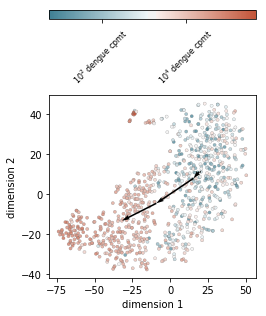

In [8]:
# Plot dimensionality reductions for all genes at the ourskirts of the correlation plot
dsd = ds.query_samples_by_metadata('numberDengueReads >= 5')
features = cos.index[np.abs(cos).max(axis=1) >= 0.4]
dsd.counts = dsd.counts.loc[features]
dsd.samplesheet['virus_log'] = np.log10(1 + dsd.samplesheet['virus_reads_per_million'])
# t-SNE is not deterministic, so save to file to make sure we can reproduce
# the paper figures with variations if needed
vs_fn = '../data/tsne_coordinates_5+dengue_reads.tsv'
if os.path.isfile(vs_fn):
    vs = pd.read_csv(vs_fn, sep='\t', index_col=0)
else:
    vs = dsd.dimensionality.tsne(perplexity=10)
    vs.to_csv(vs_fn, sep='\t')
cmap = sns.diverging_palette(220, 20, as_cmap=True, center='light')
fig, axs = plt.subplots(
        nrows=2, ncols=1, figsize=(3.8, 4.5),
        gridspec_kw={'height_ratios': [1, 20]})
axs = axs[::-1]
dsd.plot.scatter_reduced_samples(
        vs,
        color_by='virus_log',
        cmap=cmap,
        alpha=0.8,
        ax=axs[0],
        s=10,
        lw=.25,
        edgecolor=[0.4, 0.4, 0.4],
        zorder=10)
norm1 = mpl.colors.Normalize(
        vmin=dsd.samplesheet['virus_log'].values.min(),
        vmax=dsd.samplesheet['virus_log'].values.max())
cb1 = mpl.colorbar.ColorbarBase(
        ax=axs[1], cmap=cmap, norm=norm1, orientation='horizontal')
cb1.set_ticks([-4, -2, 0, 2, 4])
cb1.set_ticklabels(
        ['$10^4$ Zika cpmt', '$10^2$ Zika cpmt', 'no virus',
         '$10^2$ dengue cpmt', '$10^4$ dengue cpmt'])
for tkl in cb1.ax.get_xticklabels():
    tkl.set_rotation(45)
    tkl.set_fontsize(8)
axs[0].grid(False)

# Plot mean of samples at increasing viral load
bins = [0, 30, 200, 1000, 10000, 70000, 500000]
for virus in ['dengue', 'zika']:
    ph = dsd.samplesheet['virus_reads_per_million']
    vi = dsd.samplesheet['virus']
    vms = pd.concat([vs.loc[
        (ph >= bins[i]) & (ph < bins[i+2]) & (vi == virus)
        ].mean(axis=0) for i in range(len(bins) - 2)],
        axis=1).T
    x = vms.values[:, 0]
    y = vms.values[:, 1]
    axs[0].quiver(
            x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1],
            scale_units='xy', angles='xy', scale=1,
            zorder=20)

plt.tight_layout(h_pad=0.5, w_pad=0.1)

### Get various tsne coordinates and merge them into the pickle

In [9]:
vss = {
    'all': pd.read_csv('../data/tsne_coordinates_allcells.tsv', sep='\t', index_col=0),
    'MOI1_10': pd.read_csv('../data/tsne_coordinates_moi1-10.tsv', sep='\t', index_col=0),
    '5plus_dengue_reads': pd.read_csv('../data/tsne_coordinates_5+dengue_reads.tsv', sep='\t', index_col=0),
}
for key, val in vss.items():
    for dim in ('1', '2'):
        colname = 'tsne{:}_{:}'.format(dim, key)
        meta_felix[colname] = np.nan
        meta_felix.loc[val.index, colname] = val['dimension {:}'.format(dim)].values
with open('../data/metadataD_SNV_with_tsne.pkl', 'wb') as ff:
    pickle.dump(meta_felix, ff, protocol=-1)

In [10]:
with open('../data/metadataD_SNV_with_tsne.pkl', 'rb') as ff:
    mm = pickle.load(ff)
mm

,barcode,index,experiment,sequencingInstrument,sequencingRun,sequencingDate,cellType,qPCR,virus,numberDengueReads,...,Dn_s,depth,numSNV,coverage,tsne1_all,tsne2_all,tsne1_MOI1_10,tsne2_MOI1_10,tsne1_5plus_dengue_reads,tsne2_5plus_dengue_reads
name,,,,,,,,,,,,,,,,,,,,,
1001700601_A2,Barcode_701-502EX1,TAAGGCGA-CTCTATACGT,10017006,NextSeq,N349,2017/01/27,huh7,NaN,dengue,0,...,NaN,NaN,NaN,720998.0,20.034573,10.558477,NaN,NaN,NaN,NaN
1001700601_A4,Barcode_701-513EX1,TAAGGCGA-GACTAGACGT,10017006,NextSeq,N349,2017/01/27,huh7,NaN,dengue,0,...,NaN,NaN,NaN,584657.0,14.239581,0.226169,NaN,NaN,NaN,NaN
1001700601_A6,Barcode_701-503EX1,TAAGGCGA-TCCTCTACGT,10017006,NextSeq,N349,2017/01/27,huh7,NaN,dengue,0,...,NaN,NaN,NaN,582013.0,36.256650,16.345642,NaN,NaN,NaN,NaN
1001700601_A8,Barcode_701-515EX1,TAAGGCGA-CTAGCTACGT,10017006,NextSeq,N349,2017/01/27,huh7,NaN,dengue,0,...,NaN,NaN,NaN,651846.0,18.830437,27.432535,NaN,NaN,NaN,NaN
1001700601_B3,Barcode_701-505EX1,TAAGGCGA-AAGGAGACGT,10017006,NextSeq,N349,2017/01/27,huh7,NaN,dengue,0,...,NaN,NaN,NaN,594798.0,51.535820,9.497739,NaN,NaN,NaN,NaN
1001700601_B7,Barcode_701-516EX1,TAAGGCGA-TAGAGTACGT,10017006,NextSeq,N349,2017/01/27,huh7,NaN,dengue,0,...,NaN,NaN,NaN,755335.0,18.939692,-31.327974,NaN,NaN,NaN,NaN
1001700601_B8,Barcode_701-506EX1,TAAGGCGA-TGCATAACGT,10017006,NextSeq,N349,2017/01/27,huh7,NaN,dengue,0,...,NaN,NaN,NaN,729749.0,17.878073,-17.446693,NaN,NaN,NaN,NaN
1001700601_B10,Barcode_701-517EX1,TAAGGCGA-GTAAGAACGT,10017006,NextSeq,N349,2017/01/27,huh7,NaN,dengue,0,...,NaN,NaN,NaN,575342.0,46.623300,3.640869,NaN,NaN,NaN,NaN
1001700601_B13,Barcode_701-507EX1,TAAGGCGA-GGAGTAACGT,10017006,NextSeq,N349,2017/01/27,huh7,NaN,dengue,0,...,NaN,NaN,NaN,511666.0,38.026352,-2.151759,NaN,NaN,NaN,NaN
